# Fast.ai API

### add_datepart

In [2]:
from fastai.tabular import *

df = pd.DataFrame({'col1': ['02/03/2017', '02/04/2017', '02/05/2017'], 'col2': ['a', 'b', 'a']})
df

,col1,col2
0,02/03/2017,a
1,02/04/2017,b
2,02/05/2017,a


In [3]:
add_datepart(df, 'col1') # inplace
df.head()

,col2,col1Year,col1Month,col1Week,col1Day,col1Dayofweek,col1Dayofyear,col1Is_month_end,col1Is_month_start,col1Is_quarter_end,col1Is_quarter_start,col1Is_year_end,col1Is_year_start,col1Elapsed
0,a,2017,2,5,3,4,34,False,False,False,False,False,False,1486080000
1,b,2017,2,5,4,5,35,False,False,False,False,False,False,1486166400
2,a,2017,2,5,5,6,36,False,False,False,False,False,False,1486252800


### cont_cat_split

In [10]:
df = pd.DataFrame({'col1': [1.0, 2.0, 3.0], 'col2': ['a', 'b', 'a'], 'col3': [0.5, 1.2, 7.5], 'col4': ['ab', 'o', 'o']})
df

,col1,col2,col3,col4
0,1.0,a,0.5,ab
1,2.0,b,1.2,o
2,3.0,a,7.5,o


In [11]:
cont_list, cat_list = cont_cat_split(df=df, max_card=20, dep_var='col4')
cont_list, cat_list

(['col1', 'col3'], ['col2'])

# [Problem] Salary prediction

The dataset we are dealing with here is a relatively small dataset and good for experimentation. It deals with a bunch of adults and their characteristics and our goal is to predict if the adult’s salary is ≥ 50k or < 50k.

### Fast.ai tabular

In [16]:
from fastai.tabular import *

!rm -rf ./sample_data/ ./data/

path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [13]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


Explanation for the collumns
- education-num because it is just a numeric representation of the attribute education
- fnlwgt (final weight) - .. still unclear

In [15]:
df.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
salary             object
dtype: object

In [18]:
dep_var = 'salary'

# separate all the variables that will need to be encoded
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']

# continuous variables will not need to be encoded
cont_names = ['age', 'fnlwgt', 'education-num']

# define the procedures we will do
procs = [FillMissing, Categorify]

In [19]:
test = TabularList.from_df(df.iloc[800:1000].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

# path is just the working directory where temporary files/models will be saved.
# ... ref: https://forums.fast.ai/t/looking-for-documentation-on-path-argument-in-tabulardatabunch-from-df/34999/2

In [ ]:
test

In [21]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(800,1000)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [23]:
data.show_batch(rows=100)

workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,target
Private,11th,Married-civ-spouse,Transport-moving,Husband,White,False,37.0000,52221.0000,7.0000,<50k
Private,Assoc-acdm,Never-married,Adm-clerical,Own-child,White,False,28.0000,270973.0000,12.0000,<50k
Private,HS-grad,Married-civ-spouse,Other-service,Wife,White,False,61.0000,154600.0000,9.0000,<50k
Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,False,53.0000,194791.0000,9.0000,<50k
Private,Bachelors,Married-civ-spouse,Sales,Husband,White,False,44.0000,125461.0000,13.0000,>=50k
Self-emp-not-inc,Bachelors,Married-civ-spouse,Adm-clerical,Wife,White,False,31.0000,286282.0000,13.0000,<50k
Private,Some-college,Never-married,Craft-repair,Unmarried,White,False,20.0000,197752.0000,10.0000,<50k
Private,HS-grad,Divorced,Machine-op-inspct,Other-relative,White,False,38.0000,130813.0000,9.0000,<50k
State-gov,HS-grad,Divorced,Adm-clerical,Not-in-family,White,False,38.0000,314052.0000,9.0000,<50k
Private,Assoc-voc,Divorced,Other-service,Not-in-family,White,False,52.0000,84451.0000,11.0000,<50k


In [ ]:
# compare
# list(df.head(100)['occupation'])
# data.show_batch

In [40]:
learn = tabular_learner(data, layers=[5, 5], metrics=accuracy)

In [41]:
# fit(number_of_epochs, learning_rate)
learn.fit(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.352564,0.374468,0.830000,00:04
1,0.373442,0.383731,0.820000,00:04
2,0.360221,0.374688,0.850000,00:04
3,0.355847,0.380068,0.835000,00:04
4,0.349178,0.366416,0.845000,00:04


In [42]:
# vizualize the model
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=42, out_features=5, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=5, out_features=5, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=5, out_features=2, bias=True)
  )
)

### Random Forest

In [43]:
import pandas as pd
from fastai.tabular import *
from sklearn.ensemble import RandomForestClassifier

In [44]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [45]:
df.isnull().sum()

age                 0
workclass           0
fnlwgt              0
education           0
education-num     487
marital-status      0
occupation        512
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country      0
salary              0
dtype: int64

In [46]:
df['missing_education-num'] = df['education-num'].isnull().map({True: 1, False: 0})
df['missing_occupation'] = df['occupation'].isnull().map({True: 1, False: 0})
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,missing_education-num,missing_occupation
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k,0,1
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k,0,0
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k,1,1
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k,0,0
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k,1,0


In [47]:
val = df['education-num'].median()
df['education-num'] = df['education-num'].fillna(val)

In [48]:
val = 'no_occupation'
df['occupation'] = df['occupation'].fillna(val)

In [49]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,missing_education-num,missing_occupation
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,no_occupation,Wife,White,Female,0,1902,40,United-States,>=50k,0,1
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k,0,0
2,38,Private,96185,HS-grad,10.0,Divorced,no_occupation,Unmarried,Black,Female,0,0,32,United-States,<50k,1,1
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k,0,0
4,42,Self-emp-not-inc,82297,7th-8th,10.0,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k,1,0


In [50]:
df.isnull().sum()

age                      0
workclass                0
fnlwgt                   0
education                0
education-num            0
marital-status           0
occupation               0
relationship             0
race                     0
sex                      0
capital-gain             0
capital-loss             0
hours-per-week           0
native-country           0
salary                   0
missing_education-num    0
missing_occupation       0
dtype: int64

In [51]:
for col in df.select_dtypes(include=['object']):
    df[col] = df[col].astype('category')

In [52]:
for col in df.select_dtypes(include=['category']):
    df[col] = df[col].cat.codes

In [53]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,missing_education-num,missing_occupation
0,49,4,101320,7,12.0,2,15,5,4,0,0,1902,40,39,1,0,1
1,44,4,236746,12,14.0,0,4,1,4,1,10520,0,45,39,1,0,0
2,38,4,96185,11,10.0,0,15,4,2,0,0,0,32,39,0,1,1
3,38,5,112847,14,15.0,2,10,0,1,1,0,0,40,39,1,0,0
4,42,6,82297,5,10.0,2,8,5,2,0,0,0,50,39,0,1,0


In [54]:
def split_vals(a,n): 
  return a[:n].copy(), a[n:].copy()

In [55]:
X = df.drop('salary', axis = 1)
y = df['salary']

In [56]:
len(df)

32561

In [57]:
n_valid = int(len(df) * 0.2)  # same as Kaggle's test set size
n_trn = len(df)-n_valid

X_train, X_valid = split_vals(X, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((26049, 16), (26049,), (6512, 16), (6512,))

In [59]:
clf = RandomForestClassifier(n_jobs=-1, max_features=0.5, n_estimators=20)
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_valid)

In [60]:
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, predictions)

0.8605651105651105

#### What are the learned feature importances?

In [64]:
import pandas as pd
feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
fnlwgt,0.177547
age,0.127577
relationship,0.126905
capital-gain,0.117952
education-num,0.108256
hours-per-week,0.073263
marital-status,0.069134
occupation,0.063320
workclass,0.037870
capital-loss,0.033590


# [Problem] Buldozer price prediction [DOES NOT WORK YET]

## The problem

Predicting the sale price of bulldozers sold at auctions.

## Motivation
Tree-based models like Random Forest and XGBoost has become very poplular to address tabular(structured) data problems and gained a lot of tractions in Kaggle competitions. It has its very deserving reasons. A lot of the notebooks for this competition is inspired by fast.ai ML course. This notebook will also try to use fast.ai, but another approach: **Deep Learning**. 
This is a bit against industry consensous that Deep Learning is more for unstructured data like image, audio or NLP, and usually won't be very good at handling tabular data. Yet, the introduction of embedding for the categorical data changed this perspective and we'll try to use fast.ai's tabular model to tackle this competition and see how well a Deep Learning approach can do. 

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai import *
from fastai.tabular import *

## Load Data
After imported the necessary fast.ai modules, mainly 'fastai.tabular'. Let's load the data in. 

In [ ]:
path = Path('data')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
# copy the data over to working directory for easier manipulations
!cp -r ../input/* {path}/

cp: cannot stat '../input/*': No such file or directory


In [ ]:
path.ls()

[]

In [ ]:
ls data/bluebook-for-bulldozers

ls: cannot access 'data/bluebook-for-bulldozers': No such file or directory


In [ ]:
# read in the dataset. Since the Test.csv and Valid.csv doesn't have label, it will be used to create our own validation set. 
train_df = pd.read_csv('/kaggle/working/data/bluebook-for-bulldozers/train/Train.csv', low_memory=False, parse_dates=["saledate"])
valid_df = pd.read_csv('/kaggle/working/data/bluebook-for-bulldozers/Valid.csv', low_memory=False, parse_dates=["saledate"])
test_df = pd.read_csv('/kaggle/working/data/bluebook-for-bulldozers/Test.csv', low_memory=False, parse_dates=["saledate"])

FileNotFoundError: ignored

In [ ]:
len(train_df), len(test_df)

In [ ]:
train_df.head()

In [ ]:
len(train_df),len(valid_df), len(test_df)

## Sort the Training Set
This is to create a good validation set. It cannot be emphasised enough how important a good validation set is to making a successful model. Since we are predicting sales data in the future, we need to make a validation set that all data is collected in the 'future' of the training set. So we need to sort the training set first, then split the 'future' part as the validation set. 

In [ ]:
# Sort the dataframe on 'saledate' so we can easily create a validation set that data is in the 'future' of what's in the training set
train_df = train_df.sort_values(by='saledate', ascending=False)
train_df = train_df.reset_index(drop=True)

## Data Pre-processing
The competition's evaluation methods uses RMSLE (root mean squared log error). So if we take the log of our prediction, we can just use the good old RMSE as our loss function. It's just easier this way.

In [ ]:
# The evaluation method for this Kaggle competition is REMLE, so if we take the log on dependant variable, we can just use RSME as evaluation metrics. 
# Simpler handling this way. 
train_df.SalePrice = np.log(train_df.SalePrice)

For **Feature Engineering**, we'll just do it on the 'saledate'. We'll use the fast.ai's *add_datepart* function to achieve that. 

In [ ]:
# The only feature engineering we do is add some meta-data from the sale date column, using 'add_datepart' function in fast.ai
add_datepart(train_df, "saledate", drop=False)
add_datepart(test_df, "saledate", drop=False)

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,3,3,124,False,False,False,False,False,False,1336003200
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,10,3,131,False,False,False,False,False,False,1336608000
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,10,3,131,False,False,False,False,False,False,1336608000
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,10,3,131,False,False,False,False,False,False,1336608000
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,10,3,131,False,False,False,False,False,False,1336608000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,NaN,NaN,2012-10-24,80NX3,...,24,2,298,False,False,False,False,False,False,1351036800
12453,6643173,2558332,21434,149,2,2005,NaN,NaN,2012-10-24,28N,...,24,2,298,False,False,False,False,False,False,1351036800
12454,6643184,2558342,21437,149,2,1000,NaN,NaN,2012-10-24,35N,...,24,2,298,False,False,False,False,False,False,1351036800
12455,6643186,2558343,21437,149,2,2006,NaN,NaN,2012-10-24,35N,...,24,2,298,False,False,False,False,False,False,1351036800


In [ ]:
# check and see whether all date related meta data is added.
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
display_all(train_df.tail(10).T)

,401115,401116,401117,401118,401119,401120,401121,401122,401123,401124
SalesID,1371695,1297898,1493279,1364654,1647221,1508502,1421628,1475641,1475662,1646770
SalePrice,10.24,10.4631,11.0509,9.54681,9.61581,9.95228,11.2385,10.0648,9.9988,9.15905
MachineID,1444477,1537483,1363756,1270628,1476216,1153157,1453580,1194367,1242833,1126363
ModelID,1571,4124,2759,7289,8443,4138,3877,7277,7277,8434
datasource,132,132,132,132,132,132,132,132,132,132
auctioneerID,99,99,99,99,99,99,99,99,99,18
YearMade,1982,1978,1987,1968,1979,1972,1979,1973,1973,1974
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-17 00:00:00


It's easy to do data pre-processing in fast.ai, we just specify the pre-processing methods we want to use in a list:

In [ ]:
# Defining pre-processing we want for our fast.ai DataBunch
procs=[FillMissing, Categorify, Normalize]

Namely, we'll fix the missing values, categorify all categorical columns, then normalize. Plain and simple. 

## Building the Model


In [ ]:
train_df.dtypes
g = train_df.columns.to_series().groupby(train_df.dtypes).groups
g

{dtype('int64'): Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'YearMade', 'saleYear',
        'saleMonth', 'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
        'saleElapsed'],
       dtype='object'),
 dtype('float64'): Index(['SalePrice', 'auctioneerID', 'MachineHoursCurrentMeter'], dtype='object'),
 dtype('<M8[ns]'): Index(['saledate'], dtype='object'),
 dtype('bool'): Index(['saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end',
        'saleIs_quarter_start', 'saleIs_year_end', 'saleIs_year_start'],
       dtype='object'),
 dtype('O'): Index(['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
        'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
        'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
        'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
        'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
        'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',


Have a look at all the column types and see which are categorical and continuous. We'll use it to build the fast'ai DataBunch for training our learner. 

In [ ]:
# prepare categorical and continous data columns for building Tabular DataBunch.
cat_vars = ['SalesID', 'YearMade', 'MachineID', 'ModelID', 'datasource', 'auctioneerID', 'UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 
            'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 
            'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 
            'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls', 
            'saleYear', 'saleMonth', 'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear', 'saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end', 'saleIs_quarter_start', 'saleIs_year_end', 
            'saleIs_year_start'
           ]

cont_vars = ['MachineHoursCurrentMeter', 'saleElapsed']

In [ ]:
# rearrange training set before feed into the databunch
dep_var = 'SalePrice'
df = train_df[cat_vars + cont_vars + [dep_var,'saledate']].copy()

In [ ]:
# Look at the time period of test set, make sure it's more recent
test_df['saledate'].min(), test_df['saledate'].max()

(Timestamp('2012-05-01 00:00:00'), Timestamp('2012-11-16 00:00:00'))

Time to create our validation set. The most important step. Since this dataset is somewhat time series, we need to make sure validation set entries happens AFTER all entries in the training set, otherwise the model will be cheating and won't generalize well. 

In [ ]:
# Calculate where we should cut the validation set. We pick the most recent 'n' records in training set where n is the number of entries in test set. 
cut = train_df['saledate'][(train_df['saledate'] == train_df['saledate'][len(test_df)])].index.max()
cut

12621

In [ ]:
valid_idx = range(cut)

In [ ]:
df[dep_var].head()

0     9.998798
1     9.305651
2     9.433484
3    10.221941
4     9.975808
Name: SalePrice, dtype: float64

Utilize fast.ai's Datablock API, it's very easy to put all the training/validation dataset together for training. We pass the dataframe, categorical columns list, continous columns list, pre-processing methods list, then splid the training set into training and validation set. Specified the dependent varialble as 'SalePrice', put everything into a 'DataBunch' and get ready for training time.

In [ ]:
# Use fast.ai datablock api to put our training data into the DataBunch, getting ready for training
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList)
                   .databunch())

## Model

Finally, it's time for some training. We will fire up a fast.ai 'tabular.learner' from the DataBunch we just created.

In [ ]:
# We want to limit the price range for our prediction to be within the history sale price range, so we need to calculate the y_range
# Note that we multiplied the maximum of 'SalePrice' by 1.2 so when we apply sigmoid, the upper limit will also be covered. 
max_y = np.max(train_df['SalePrice'])*1.2
y_range = torch.tensor([0, max_y], device=defaults.device)
y_range

tensor([ 0.0000, 14.2363], device='cuda:0')

In [ ]:
# Create our tabular learner. The dense layer is 1000 and 500 two layer NN. We used dropout, hai 
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

The single most important thing about fast.ai tabular_learner is the use of embedding layers for categorical data. This is the 'secret sause' that enable Deep Learning to be competitive on handling tabular data. With one embedding layer for each categorical variable, we introduced good interaction for the categorical variables and leverage Deep Learning's biggest strengh: Automatic Feature Finding. We also used Drop Out for both the dense layers and embedding layers for better regularization. The metrics of the learner is RMSE since we've already take the log of SalePrice. Let's look at the model. 

In [ ]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(388505, 600)
    (1): Embedding(72, 18)
    (2): Embedding(331868, 600)
    (3): Embedding(5155, 192)
    (4): Embedding(6, 4)
    (5): Embedding(31, 11)
    (6): Embedding(4, 3)
    (7): Embedding(4939, 187)
    (8): Embedding(1935, 111)
    (9): Embedding(174, 29)
    (10): Embedding(122, 24)
    (11): Embedding(139, 25)
    (12): Embedding(7, 5)
    (13): Embedding(75, 18)
    (14): Embedding(54, 15)
    (15): Embedding(7, 5)
    (16): Embedding(7, 5)
    (17): Embedding(5, 4)
    (18): Embedding(7, 5)
    (19): Embedding(3, 3)
    (20): Embedding(5, 4)
    (21): Embedding(4, 3)
    (22): Embedding(3, 3)
    (23): Embedding(9, 5)
    (24): Embedding(3, 3)
    (25): Embedding(3, 3)
    (26): Embedding(7, 5)
    (27): Embedding(4, 3)
    (28): Embedding(3, 3)
    (29): Embedding(13, 7)
    (30): Embedding(3, 3)
    (31): Embedding(5, 4)
    (32): Embedding(3, 3)
    (33): Embedding(4, 3)
    (34): Embedding(18, 8)
    (35): Embe

As can be seen from the above, we have embedding layers for categorical columns, then followed by a drop out layer. We have batch norm layer for the continuous columns, then we put all of them into two fully connected layers with 1000 and 500 nodes, with Relu, BatchNorm, and Dropout in between. Quite standard.

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


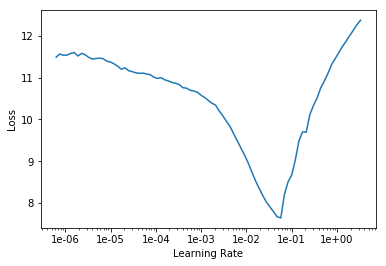

In [ ]:
learn.recorder.plot()

User fast.ai's *lr_find* function to find the proper learning rate, then do a 'fit one cycle' training. 

In [ ]:
learn.fit_one_cycle(2, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time


In [ ]:
learn.fit_one_cycle(5, 3e-4, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.040823,0.055024,0.231387,10:36
1,0.029508,0.052959,0.227219,10:37
2,0.030413,0.061524,0.244652,10:39
3,0.014952,0.053395,0.227940,10:38


In [ ]:
# learn.fit_one_cycle(5, 3e-4, wd=0.2)

Best result reaches 0.227 RMSLE, I think it beats the #1 in Kaggle leaderboard. 

## Conlusion
I think overall people still prefer XGBoost or Random Forest for tabular Kaggle competitions since it usually will yield the best scores. However, Deep Learning is also a viable approach, though lacking a bit on the explainability side. At least it could be used for ensamble purpose so it's worth exploring. 

## TODO:
- Solve the buldozer problem, add validation / accuracy data
- Add DecisionTree, RandomForest, XGB solutions to verify against DL